# Predicting 30 yr Mortgage Loan Interest Rates based on Fico scores
### Single Family, Refiance only

### Introduction

**Step 1**:
Clean and prepare the data. 

**Step 2**:
Build several machine learning models in Python to predict the "quality" of interest rates
you can expect given your Fico Score. Categories are "Worst","Bad","Par","Good","Best". The interest rate obtained is compared to the 30yr Freddie Mac rate for the week of the origination of the loan and then binned based % above or below the benchmark rate.
Train the model on the training data, and run the model on the
testing data.

**Step 3**:
Score the model by different metrics.

## Import Dependencies

In [67]:
# import necessary python modules for analysis
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error
import seaborn as sns

## Step 1: Import, clean and prepare the data:

Let's first import the data

In [68]:
# import Fannie19Q1ing_data via pandas module
Fannie19Q1 = pd.read_csv("data/Acquisition/Fannie19Q1_refi_avgfico.csv", low_memory=False)

In [69]:
Fannie19Q1['origDate'] = pd.to_datetime(Fannie19Q1['origDate'])

In [70]:
Fannie19Q1.shape

(28939, 19)

In [71]:
Fannie19Q1.head()

,sellerName,origChannel,origIntRate,origUPB,origDate,firstPmtDate,origLTV,origCLTV,numBorrowers,origDebtIncRatio,borrCreditScore,BestCreditScore,WorstCreditScore,AvgCreditScore,loanPurp,propState,zipCode,pMIperct,mortInsType
0,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",1,4.625,160000,2019-02-01,4/1/2019,80,80,2,34,758,758,752,755.0,C,IN,462,0,0
1,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",1,4.500,510000,2019-02-01,4/1/2019,64,64,2,40,772,772,767,769.5,C,CA,913,0,0
2,OTHER,1,4.750,256000,2019-01-01,3/1/2019,63,63,1,47,786,786,786,786.0,C,CA,917,0,0
3,QUICKEN LOANS INC.,1,5.500,60000,2019-01-01,3/1/2019,25,25,1,45,766,766,766,766.0,C,FL,339,0,0
4,"WELLS FARGO BANK, N.A.",2,4.625,175000,2019-01-01,3/1/2019,72,72,2,47,704,730,704,717.0,C,SC,296,0,0


In [72]:
corr = Fannie19Q1.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Fannie 2019 Q1 avg Fico scores dataset')

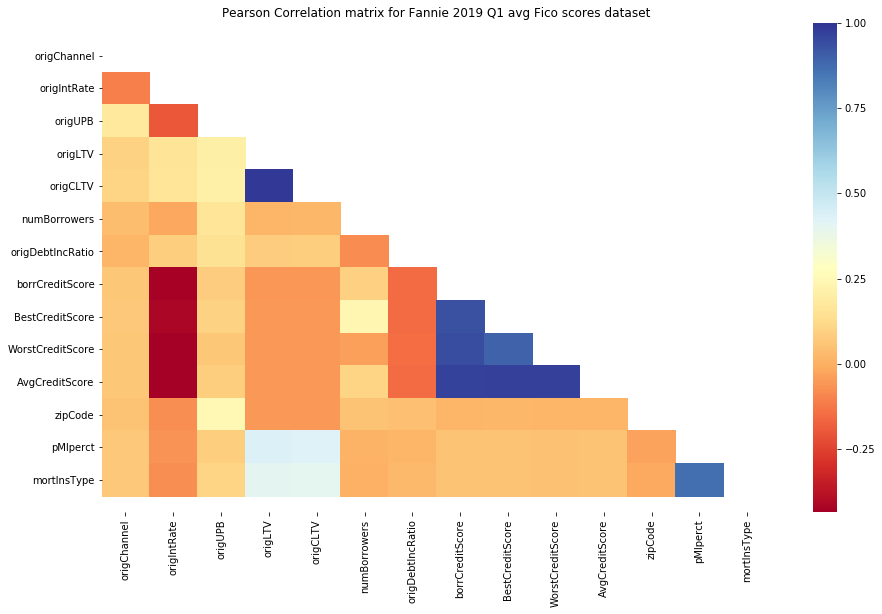

In [73]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Fannie 2019 Q1 avg Fico scores dataset')

In [74]:
Fannie19Q1.head()

,sellerName,origChannel,origIntRate,origUPB,origDate,firstPmtDate,origLTV,origCLTV,numBorrowers,origDebtIncRatio,borrCreditScore,BestCreditScore,WorstCreditScore,AvgCreditScore,loanPurp,propState,zipCode,pMIperct,mortInsType
0,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",1,4.625,160000,2019-02-01,4/1/2019,80,80,2,34,758,758,752,755.0,C,IN,462,0,0
1,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",1,4.500,510000,2019-02-01,4/1/2019,64,64,2,40,772,772,767,769.5,C,CA,913,0,0
2,OTHER,1,4.750,256000,2019-01-01,3/1/2019,63,63,1,47,786,786,786,786.0,C,CA,917,0,0
3,QUICKEN LOANS INC.,1,5.500,60000,2019-01-01,3/1/2019,25,25,1,45,766,766,766,766.0,C,FL,339,0,0
4,"WELLS FARGO BANK, N.A.",2,4.625,175000,2019-01-01,3/1/2019,72,72,2,47,704,730,704,717.0,C,SC,296,0,0


## Get Freddie Mac 30 yr weekly rate

In [75]:
# import training_data via pandas module
fmac30 = pd.read_csv("data/FMAC-30US.csv", low_memory=False)

In [76]:
fmac30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565 entries, 0 to 2564
Data columns (total 2 columns):
Date     2565 non-null object
Value    2565 non-null float64
dtypes: float64(1), object(1)
memory usage: 40.2+ KB


In [77]:
fmac30.head()

,Date,Value
0,4/2/1971,7.33
1,4/9/1971,7.31
2,4/16/1971,7.31
3,4/23/1971,7.31
4,4/30/1971,7.29


In [78]:
fmac30['Date'] = pd.to_datetime(fmac30['Date'])

In [79]:
fmac30 = fmac30[(fmac30['Date'] > '12/28/1999') & (fmac30['Date'] < '4/1/2019')]

In [80]:
fmac30.head()

,Date,Value
1500,1999-12-31,8.06
1501,2000-01-07,8.15
1502,2000-01-14,8.18
1503,2000-01-21,8.26
1504,2000-01-28,8.25


In [81]:
fmac30 = fmac30.set_index('Date').resample('D').ffill().reset_index()

In [82]:
fmac30 = fmac30.rename(columns={'Date':'origDate','Value':'fmacRate'})

In [83]:
fmac30.head()

,origDate,fmacRate
0,1999-12-31,8.06
1,2000-01-01,8.06
2,2000-01-02,8.06
3,2000-01-03,8.06
4,2000-01-04,8.06


## Get 10 yr Treasury daily rate

In [84]:
# import training_data via pandas module
fred10 = pd.read_csv("data/FRED-DGS10.csv", low_memory=False)

In [85]:
fred10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14575 entries, 0 to 14574
Data columns (total 2 columns):
Date     14575 non-null object
Value    14575 non-null float64
dtypes: float64(1), object(1)
memory usage: 227.8+ KB


In [86]:
fred10.head()

,Date,Value
0,1/2/1962,4.06
1,1/3/1962,4.03
2,1/4/1962,3.99
3,1/5/1962,4.02
4,1/8/1962,4.03


In [87]:
fred10['Date'] = pd.to_datetime(fred10['Date'])

In [88]:
fred10 = fred10[(fred10['Date'] > '12/28/1999') & (fred10['Date'] < '4/1/2019')]

In [89]:
fred10 = fred10.set_index('Date').resample('D').ffill().reset_index()

In [90]:
fred10 = fred10.rename(columns={'Date':'origDate','Value':'fredRate'})

In [91]:
fred10.head()

,origDate,fredRate
0,1999-12-29,6.40
1,1999-12-30,6.39
2,1999-12-31,6.45
3,2000-01-01,6.45
4,2000-01-02,6.45


## Merge data

In [92]:
# Merge data
merged = pd.merge(Fannie19Q1, fmac30, on=["origDate"])
merged.shape

(28939, 20)

In [93]:
# Merge data
merged = pd.merge(merged, fred10, on=["origDate"])
merged.shape

(28939, 21)

In [94]:
merged['rateDiff'] = merged['origIntRate'] - merged['fmacRate']

In [95]:
merged['rateDiffPct'] = merged['rateDiff'] / merged['fmacRate']

In [96]:
merged.shape

(28939, 23)

In [97]:
merged.head()

,sellerName,origChannel,origIntRate,origUPB,origDate,firstPmtDate,origLTV,origCLTV,numBorrowers,origDebtIncRatio,...,AvgCreditScore,loanPurp,propState,zipCode,pMIperct,mortInsType,fmacRate,fredRate,rateDiff,rateDiffPct
0,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",1,4.625,160000,2019-02-01,4/1/2019,80,80,2,34,...,755.0,C,IN,462,0,0,4.46,2.7,0.165,0.036996
1,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",1,4.500,510000,2019-02-01,4/1/2019,64,64,2,40,...,769.5,C,CA,913,0,0,4.46,2.7,0.040,0.008969
2,QUICKEN LOANS INC.,0,4.750,143000,2019-02-01,4/1/2019,68,68,1,16,...,674.0,C,NC,286,0,0,4.46,2.7,0.290,0.065022
3,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",1,4.500,160000,2019-02-01,4/1/2019,17,17,1,43,...,738.0,C,CA,920,0,0,4.46,2.7,0.040,0.008969
4,PENNYMAC CORP.,2,4.500,320000,2019-02-01,4/1/2019,74,74,2,26,...,729.0,R,LA,707,0,0,4.46,2.7,0.040,0.008969


In [129]:
# Save the data prior to the binning steps
merged.to_csv('data/FannieAcq2019Q1FMac30.csv')

## Create Classes for the rateDiffPct field
#### rateDiffPct is the difference between the origination Interest Rate for the loan and the Freddie Mac 30 year Mortgage rate for the week of the origination of the loan. We want to bin rates by what % the differed from the published FMAC rate.

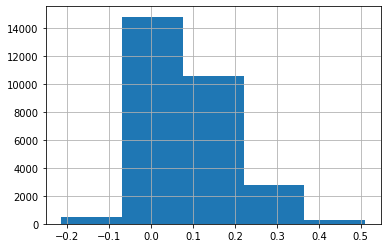

In [98]:
merged['rateDiffPct'].hist(bins=5)

In [99]:
bin_width = (merged['rateDiffPct'].max() - merged['rateDiffPct'].min())/5

In [100]:
bin_width

0.1452471295520623

In [101]:
merged['rateDiffPct'].describe()

count    28939.000000
mean         0.090866
std          0.094903
min         -0.215247
25%          0.034483
50%          0.071429
75%          0.126374
max          0.510989
Name: rateDiffPct, dtype: float64

In [115]:
merged['rateDiffPct'].value_counts(bins=7, sort=False)

(-0.217, -0.111]        105
(-0.111, -0.00775]     3923
(-0.00775, 0.096]     13456
(0.096, 0.2]           7225
(0.2, 0.303]           3325
(0.303, 0.407]          820
(0.407, 0.511]           85
Name: rateDiffPct, dtype: int64

In [122]:
merged['rank'] = pd.cut(merged['rateDiffPct'], 9, labels=[0,1,2,3,4,5,6,7,8])

In [123]:
merged['rank'] = pd.to_numeric(merged['rank'])

In [124]:
merged['rank'].value_counts()

3    12233
2     6189
4     5459
5     2697
6     1233
1      780
7      262
0       46
8       40
Name: rank, dtype: int64

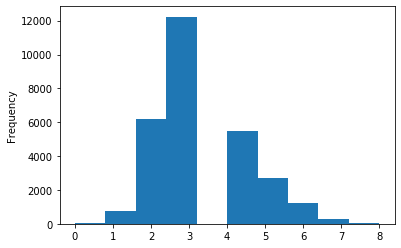

In [125]:
merged['rank'].plot(kind='hist')

In [126]:
merged.head()

,sellerName,origChannel,origIntRate,origUPB,origDate,firstPmtDate,origLTV,origCLTV,numBorrowers,origDebtIncRatio,...,loanPurp,propState,zipCode,pMIperct,mortInsType,fmacRate,fredRate,rateDiff,rateDiffPct,rank
0,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",1,4.625,160000,2019-02-01,4/1/2019,80,80,2,34,...,C,IN,462,0,0,4.46,2.7,0.165,0.036996,3
1,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",1,4.500,510000,2019-02-01,4/1/2019,64,64,2,40,...,C,CA,913,0,0,4.46,2.7,0.040,0.008969,2
2,QUICKEN LOANS INC.,0,4.750,143000,2019-02-01,4/1/2019,68,68,1,16,...,C,NC,286,0,0,4.46,2.7,0.290,0.065022,3
3,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",1,4.500,160000,2019-02-01,4/1/2019,17,17,1,43,...,C,CA,920,0,0,4.46,2.7,0.040,0.008969,2
4,PENNYMAC CORP.,2,4.500,320000,2019-02-01,4/1/2019,74,74,2,26,...,R,LA,707,0,0,4.46,2.7,0.040,0.008969,2


In [128]:
merged.to_csv('data/FannieAcq2019Q1FMac30bin9.csv')

In [130]:
pip install pandas-profiling

  Stored in directory: C:\Users\Kip Madden\AppData\Local\pip\Cache\wheels\43\07\ac\7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Stored in directory: C:\Users\Kip Madden\AppData\Local\pip\Cache\wheels\f6\8b\23\41a1b516f6d8d4cc81f5bdb55394a47cdbe9659c53668d3c9e
  Stored in directory: C:\Users\Kip Madden\AppData\Local\pip\Cache\wheels\07\1c\dc\6831446f09feb8cc199ec73a0f2f0703253f6ae013a22f4be9
Successfully built htmlmin confuse imagehash
  Found existing installation: Jinja2 2.10.1
    Uninstalling Jinja2-2.10.1:
Note: you may need to restart the kernel to use updated packages.


ERROR: phik 0.9.11 has requirement joblib>=0.14.1, but you'll have joblib 0.13.2 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\jinja2-2.10.1.dist-info\\entry_points.txt'
Consider using the `--user` option or check the permissions.

